In [90]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import json
import math

plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (7/1.5,7/1.5)
plt.rcParams["figure.dpi"] = 200

In [91]:
import neurenorm

In [92]:
data = neurenorm.load_data("data.tif")

In [93]:
# This returns a list of the different renormalization steps
clusterings = {}
rdata = {} #< renormalized data
strategies = ['correlation', 'random']
for strategy in strategies:
    clusterings[strategy] = neurenorm.cluster_recursive(data, 9, clustering_strategy=strategy)
    rdata[strategy] = [neurenorm.apply_clustering(data, clusters) for clusters in clusterings[strategy]]

In [94]:
def sorted_eigenvals_for_cluster(data, cluster):
    corr_coef = neurenorm.compute_correlation_coefficients(data[cluster])
    eig_vals, _ = np.linalg.eig(corr_coef)
    return -np.sort(-eig_vals)

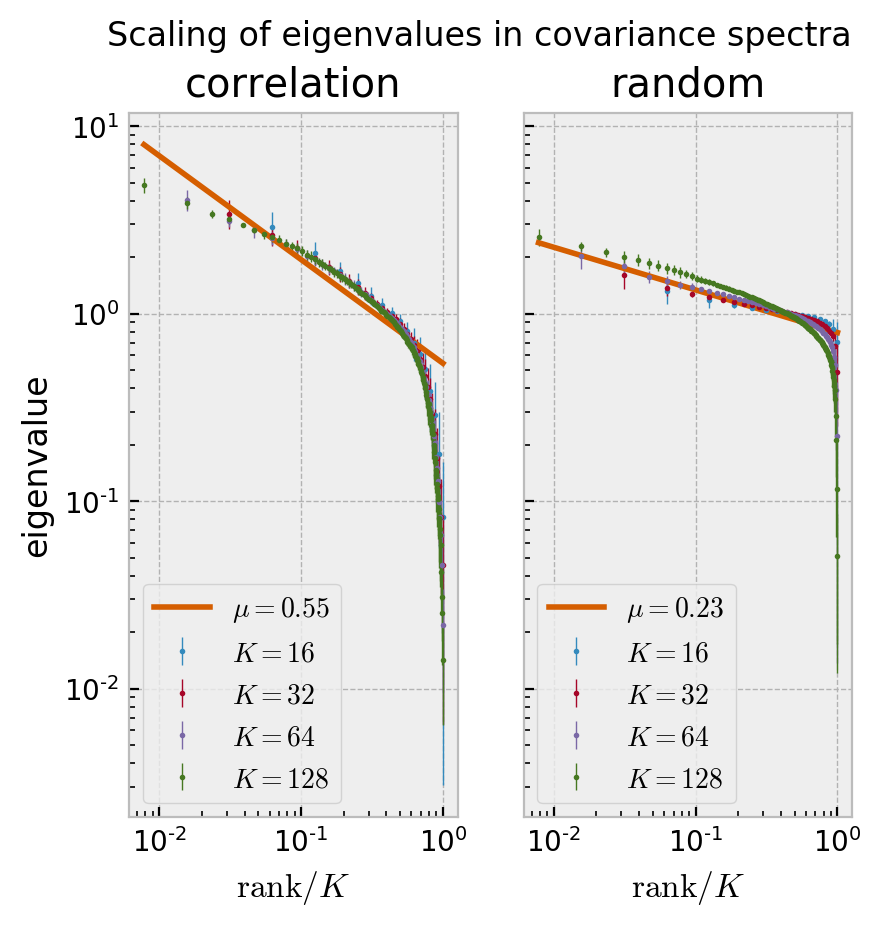

In [119]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True)
fig.suptitle('Scaling of eigenvalues in covariance spectra')
for plot_i, (ax, strategy) in enumerate(zip(axs, strategies)):
    popt_arr = []
    for index in range(4,8):
        size_k = 2**index
        clusters = clusterings[strategy][index].T
        eigen_vals = np.zeros_like(clusters, float)
        for jdex, cluster in enumerate(clusters):
            eigen_vals[jdex][...] = sorted_eigenvals_for_cluster(data, cluster)

        # eigenvalues and errors
        eig_vals_mean = np.mean(eigen_vals, axis=0)
        eig_vals_err = np.std(eigen_vals, axis=0, ddof=1)

        # Fitting
        rank = np.arange(1, len(eig_vals_mean) + 1)
        lamda = lambda rank, mu, b: b * np.power(size_k / rank, mu)
        popt, perr = curve_fit(lamda, rank, eig_vals_mean)
        popt_arr.append(popt)

        # plotting
        ax.errorbar(rank / size_k, eig_vals_mean, yerr=eig_vals_err, fmt='o', markersize=1, elinewidth=0.5, label="$K={}$".format(size_k))

    mu, b = np.mean(popt_arr, axis=0)
    x = np.linspace(1/2**7, 1.0, 10)
    ax.plot(x, b * np.power(1.0/x, mu), label="$\mu={:.2}$".format(mu))

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('$\mathrm{rank} / K$')
    axs[0].set_ylabel('eigenvalue')
    ax.set_title(strategy)
    ax.legend(loc=0)

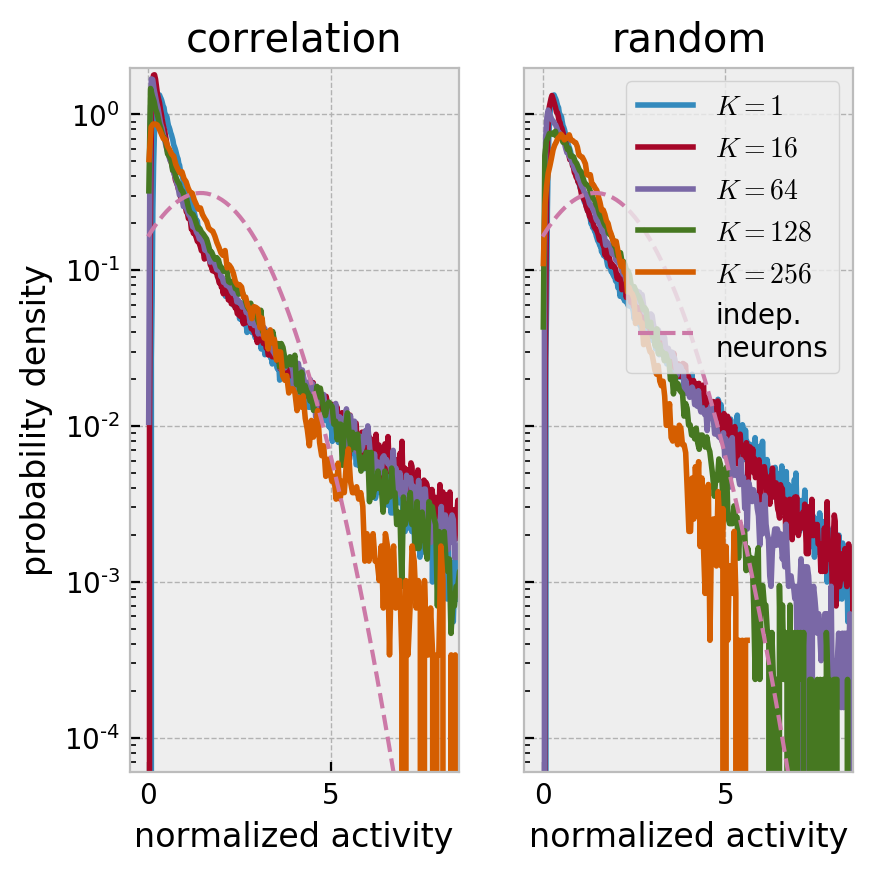

In [135]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True)
for plot_i, (ax, strategy) in enumerate(zip(axs, strategies)):
    for i in [0, 4, 6, 7, 8]:
        x, y = neurenorm.make_histogram(rdata[strategy][i])
        ax.set_yscale('log')
        ax.set_xlim(-0.5,8.5)
        ax.plot(x, y, label="$K={}$".format(2**i))

    x = np.linspace(0,10,100)
    empirical_samples = rdata[strategy][0][rdata[strategy][0] > .5]
    std_deviation = np.std(empirical_samples, ddof=1)
    mean = np.mean(empirical_samples)
    gaussian = 1/(np.sqrt(2*math.pi) * std_deviation) * np.exp(-((x - mean)/std_deviation)**2/2.0)
    ax.plot(x, gaussian, "--", label="indep.\nneurons", linewidth=1.5)

    ax.set_xlabel('normalized activity')
    ax.set_ylim(0.6*10**-4, 2)
    ax.set_title(strategy)

axs[0].set_ylabel('probability density')  
axs[1].legend(loc=1)

In [137]:
def neg_log(data):
    return -np.log(data)

Text(0, 0.5, '$-\\ln(P_0)$')

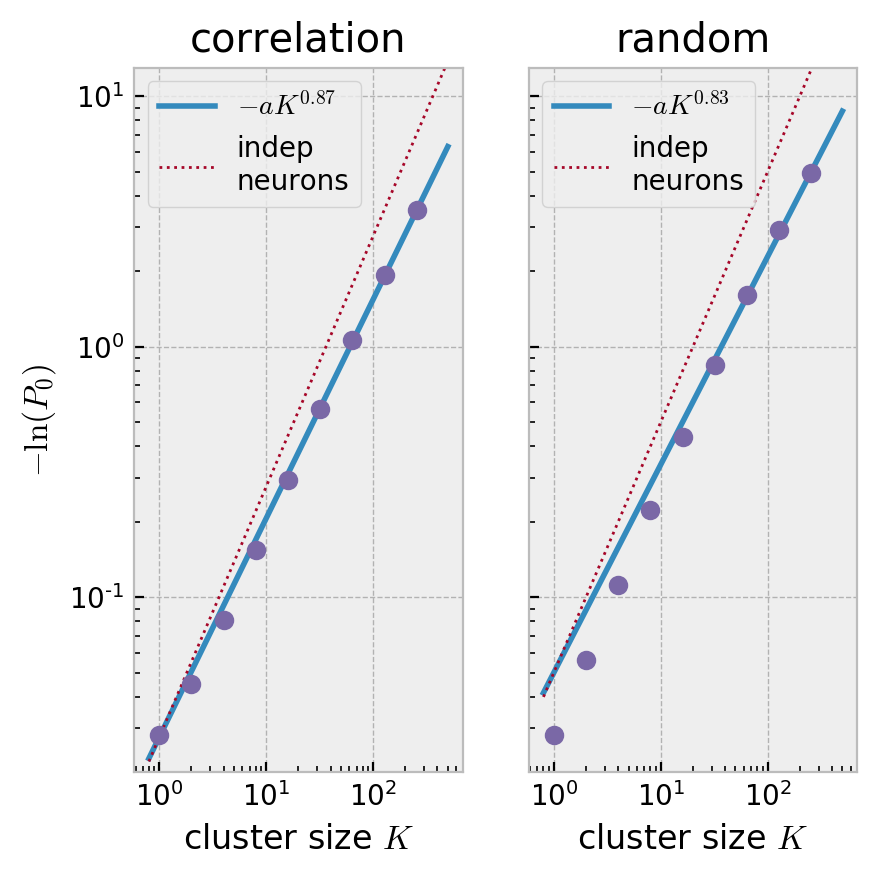

In [142]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True)
for plot_i, (ax, strategy) in enumerate(zip(axs, strategies)):
    p_zero, p_errs, cluster_sizes = neurenorm.compute_p_trajectory(rdata[strategy][:-1])

    # Fitting the exponents to the P_0 curve

    f = lambda x, beta, a: -a * np.power(x, beta)
    popt, perr = curve_fit(f, cluster_sizes, neg_log(p_zero))

    x = np.linspace(.8, 500, 100)
    ax.plot(x, f(x, *popt), 'C0-', label="$-a K^{{{:.2}}}$".format(popt[0]))
    ax.plot(x, f(x, 1.0, popt[1]), 'C1:', linewidth=1, label="indep\nneurons")
    ax.errorbar(cluster_sizes, neg_log(p_zero), fmt='C2o')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(.02, 13)
    ax.set_xlabel('cluster size $K$')
    ax.legend(loc=2)
    ax.set_title(strategy)


axs[0].set_ylabel('$-\ln(P_0)$')

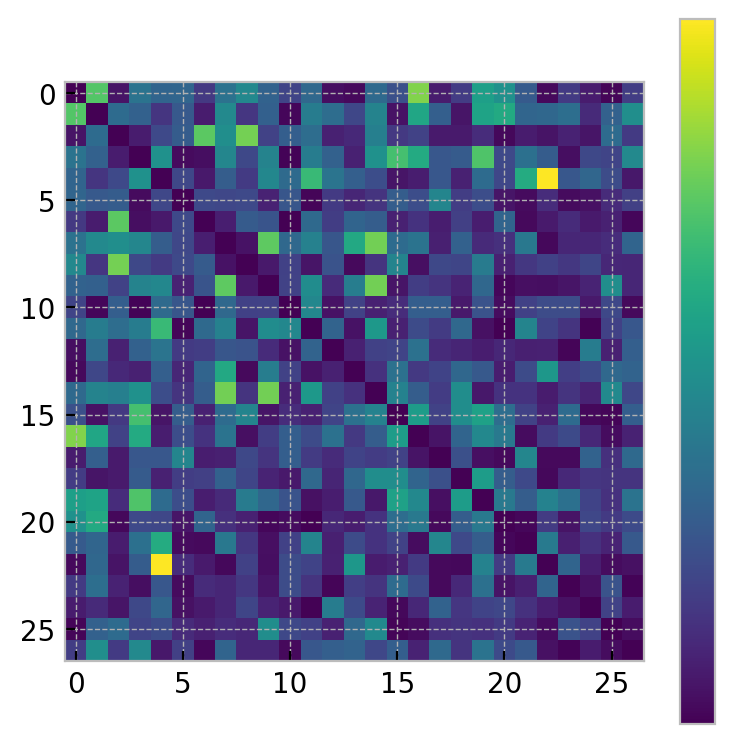

In [143]:
matrix = neurenorm.compute_correlation_coefficients(rdata['correlation'][5])
matrix = np.abs(matrix - np.identity(len(matrix)))
plt.imshow(matrix, interpolation='nearest')
colorbar = plt.colorbar(ticks = [])

In [144]:
regions_filename = './consensus_regions.json' # for other files change path accordingly
with open(regions_filename) as f:
    regions = json.load(f)

dims = [0,0]
for s in regions:
    max_x = np.max(np.array(s['coordinates'])[:,0])
    max_y = np.max(np.array(s['coordinates'])[:,1])
    dims[0] = max_x if max_x > dims[0] else dims[0]
    dims[1] = max_y if max_y > dims[1] else dims[1]
dims = (dims[0] + 1, dims[1] + 1)    

def tomask(coords):
    coords = np.array(coords)
    mask = np.zeros(dims)
    mask[coords.T[0], coords.T[1]] = 1
    return mask

masks = np.array([tomask(s['coordinates']) for s in regions])

In [145]:
def cluster_with_color(cluster, masks, color, alpha=None):
    color = matplotlib.colors.to_rgba_array(color, alpha)[0]
    cluster_im = np.sum(masks[cluster], axis=0)
    s = cluster_im.shape
    rgb_im = np.zeros((s[0], s[1], color.shape[0]))
    rgb_im[cluster_im > 0] = color
    return rgb_im

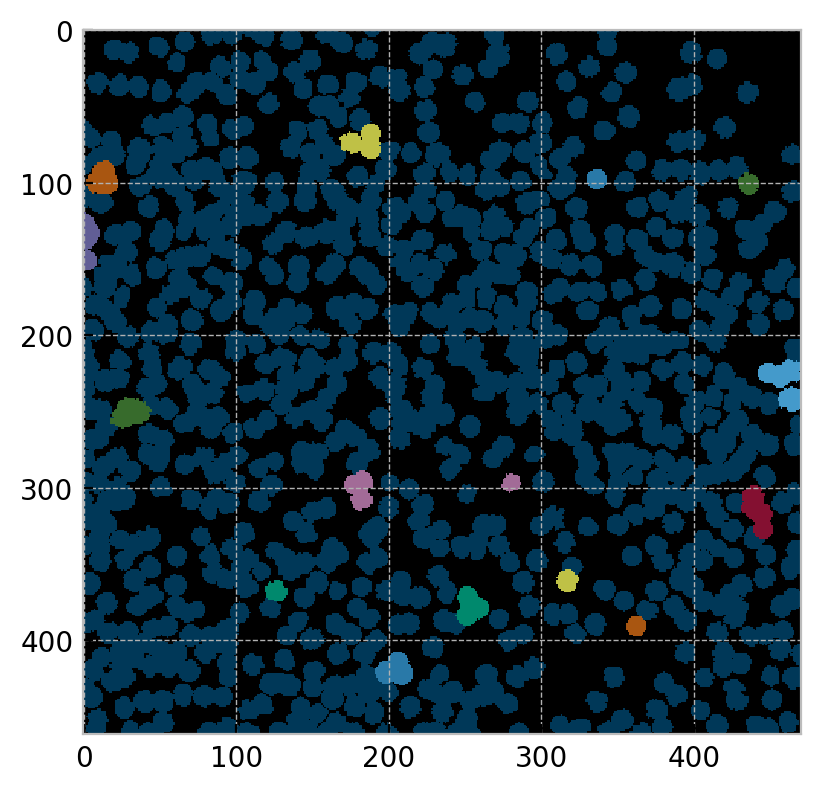

In [147]:
# show the outputs
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_facecolor('black')


background = cluster_with_color(np.arange(len(masks)), masks, 'C9', 0.5)
plt.imshow(background)
for cluster_index in range(9):
    color = 'C{}'.format(cluster_index % 9)
    cluster = clusterings['correlation'][2].T[cluster_index]
    im = cluster_with_color(cluster, masks, color, 0.8)
    plt.imshow(im)
    
plt.show()

In [19]:
masks[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])